# NLP - M2 MAS

## Maël Mandard - Ewen Le Cunff

Notre projet de NLP se base sur des données récupérées sur l'API de la cour de cassation. Nous avons choisi les données correspondant à la formation et à la rupture de contrat de travail. Nous avons 500 textes pour chaque catégorie. 
Nous allons nous demander à quelle précision pourrons-nous classifier les textes juridiques dans nos deux catégories (formation et rupture de contrat de travail). Pour cela, nous devrons préparer, nettoyer et visualiser les données afin de bien se les approprier. Pour finir, nous nous demanderons quels sont les thématiques qui ressortent le plus souvent de tous ces textes en ne prenant pas en compte les deux catégories de base.

Voici le lien GitHub de notre travail : https://github.com/elecunff/M2_NLP_Mandard_LeCunff

### SOMMAIRE

1. Chargement des librairies
2. Chargement de données
3. Préparation / Nettoyage des données
4. Visualisation des données
5. Analyse des documents
6. Classification des documents
7. LDA (Latent Dirichlet Allocation)
8. LSA (Latent Semantic Analysis)
9. Conclusion

#### Chargement des librairies

In [1]:
import json
import pandas as pd
import re
from unidecode import unidecode
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from prince import MCA
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

#### Chargement des données

In [2]:
# Liste des noms des fichiers d'entrée
liste = ['formation0', 'formation1', 'formation2', 'formation3', 'formation4',
         'rupture0', 'rupture1', 'rupture2', 'rupture3', 'rupture4']

date = []
texte = []
theme = []

# Boucle pour importer les fichiers et les concaténer
for obj in liste :
    #f = open(f"C:/Users/Mael/Documents/Fac/M2/NLP/M2_NLP_Mandard_LeCunff/Data/{obj}.json", encoding= 'UTF-8')
    f = open(f"C:/Users/ewen/Documents/M2/NLP/M2_NLP_Mandard_LeCunff/Data/{obj}.json", encoding= 'UTF-8')
    
    data = json.load(f)
    
    them = data['query']['theme']
    
    results = data['results']
    
    for res in results : 
        theme.append(them[0])
        date.append(res['decision_date'])
        texte.append(res['text'])
    
# Récupération de la date, du thème et du texte
fin_data = pd.DataFrame({'date' : date, 'theme' : theme, 'texte' : texte})

Nous chargeons les données dans un DataFrame en enregistrant la date, le thème et le texte du document que nous allons analyser.

#### Préparation/Nettoyage de données

Nous supprimons les entités nommées (noms de personnes, d'organisations, de lieux) de nos textes car ce ne sont pas des données intéressantes pour la suite de notre travail. En effet, lors de notre première analyse nous retrouvions des noms d'entreprises dans notre nuage de mots et dans l'analyse de thématiques.

In [3]:
# Chargement du modèle de traitement du langage naturel Spacy pré-entraîné "fr_core_news_sm" pour la langue française
# Commande à réaliser dans le terminal pour le télécharger avant de le charger : python -m spacy download fr_core_news_sm
nlp = spacy.load('fr_core_news_sm') 

# Fonction qui supprime les entités nommées des documents.
def remove_named_entities(text):
    doc = nlp(text)
    new_tokens = (token.text for token in doc if token.ent_type_ == '')
    return ' '.join(new_tokens)

# Création d'une nouvelle colonne pour conserver le texte original
fin_data['text-entite-nommee'] = fin_data['texte'].apply(lambda x: remove_named_entities(x))

Ensuite nous mettons le texte en minuscule.

In [4]:
# Fonction qui permet de mettre les textes en minuscule
def mise_en_minuscule(text):
    return text.replace(text, text.lower())

# Création d'une colonne texte propre qui sera utilisée pour la visualisation du nuage de mots
fin_data['texte_propre'] = fin_data['text-entite-nommee'].apply(lambda x: mise_en_minuscule(x))

Nous supprimons tous les accents.

In [5]:
# Fonction qui permet de supprimer les accents
def remove_accents(text) : 
    return unidecode(text)

fin_data['texte_propre'] = fin_data['texte_propre'].apply(lambda x: remove_accents(x))

Nous nettoyons ensuite le texte, c'est à dire qu'on remplace les caractères non alphanumériques en espace pour éviter les problèmes avec les "l'", "n'", etc... Par exemple l'objectif est d'éviter que le mot "l'ancien" devienne "lancien". Nous nettoyons aussi les mots qui contiennent un chiffre et les mots qui contiennent une seule lettre.

In [6]:
# Fonction qui permet de nettoyer le texte
def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text) #supprimer les caractères non alphanumériques
    text = re.sub(r'\b\d+\b', '', text) #supprimer les mots qui contiennent un chiffre
    text = re.sub(r'\b\w\b', '', text) #supprimer les mots qui contiennent une seule lettre
    return text

fin_data['texte_propre'] = fin_data['texte_propre'].apply(lambda x: clean_text(x))

Par la suite nous supprimons les stopwords. Les stopwords sont téléchargés grâce à la librairie nltk, nous ajoutons à la liste des mots à la main car la liste de mots vides n'était pas complète pour nous.

In [7]:
# Fonction qui permet de supprimer les stopwords
def supprime_stopwords(text, stop_words, rare_threshold=0.2):
    words = re.split(r"[ ]", text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Téléchargement des stopwords de la librairie nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

# Ajout de la liste de stopwords créée à la main.
liste_stop = ['apos', 'meme', 'sans', 'ni', 'lors', 'etre', 'eter', 'cour', 'faire', 'ete', 'non', 'moyen', 'pouvoir', 'avoir', 'plus', 'etant', 
              'article', 'salarie', 'contrat', 'arret', 'code', 'travail', 'societe', 'employeur', 'appel', 
              'janvier', 'fevrier', 'mars', 'avril', 'mai', 'juin', 'juillet', 'aout', 'septembre', 'octobre', 'novembre', 'decembre',
              'celui', 'celle', 'cette', 'ainsi', 'donc', 'dont', 'si', 'ci', 'etait', 'part', 'tout', 'alors', 'mois', 'selon',
              'apre', 'deux', 'date', 'party', 'lequel', 'mettre', 'comme', 'deg']
stop_words.update(liste_stop)

fin_data['texte_propre'] = fin_data['texte_propre'].apply(lambda x: supprime_stopwords(x, stop_words))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ewen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


On supprime les espaces mutliples dans notre texte car lorsqu'on supprime un mot c'est possible d'avoir plusieurs espaces d'affilé.

In [8]:
# Fonction qui permet de supprimer les espaces multiples
def supprime_espace(text):
    words = re.split(r"[ ]", text)
    filtered_words = [word for word in words if word]
    return ' '.join(filtered_words)

fin_data['texte_propre'] = fin_data['texte_propre'].apply(lambda x: supprime_espace(x))

Pour finir, on lemmatise les mots de nos textes pour regrouper les mots de la même famille et donc avoir une simplification du texte pour réaliser une meilleure analyse.

In [9]:
# Fonction qui lemmatise les mots de nos textes
def lemmatisation(text, stop_words):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words]
    return ' '.join(lemmatized_tokens)

# Création d'une nouvelle colonne qui nous servira pour l'analyse des documents
fin_data['texte_lemma'] = fin_data['texte_propre'].apply(lambda x: lemmatisation(x, stop_words))

#### Visualisation des données

Création d'un nuage de mots pour avoir une visualisation des mots ou expressions les plus utilisées dans les textes juridiques.
Nous faisons ce nuage de mots avec les données nettoyées mais pas lemmatisées pour avoir plus de réalité dans les mots qui s'affichent. 

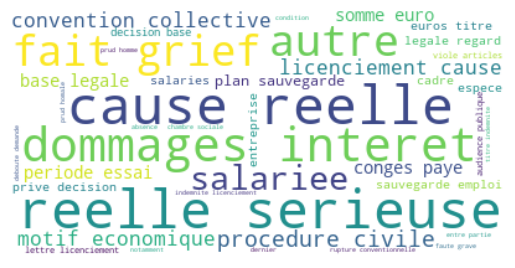

In [10]:
# Création du nuage de mots
wordcloud = WordCloud(background_color="white", max_words = 40)
text = " ".join(fin_data['texte_propre'].tolist()) 
wordcloud.generate(text)

# Affichage du nuage de mots
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

On remarque ici dans le nuage de mots que les mots/expressions suivantes sont les plus utilisées :

1. Dommage interêt 
2. Fait grief
3. Salariée

Nous retrouvons aussi en plus petit des expressions comme :

1. Convention collective
2. Motif économique
3. Période d'essai 
4. Procédure civile
5. Congés payé
6. Licenciement cause

On retrouve bien le vocabulaire associé à notre thématique qui porte sur la formation et la rupture de contrat de travail.

#### Analyse des documents

Création de la matrice document-terme, c'est une matrice qui montre la fréquence des termes qui apparaissent dans les documents.

In [11]:
# Création de la matrice document-terme
vec = CountVectorizer()
X_doc_terme = vec.fit_transform(fin_data['texte_lemma'])

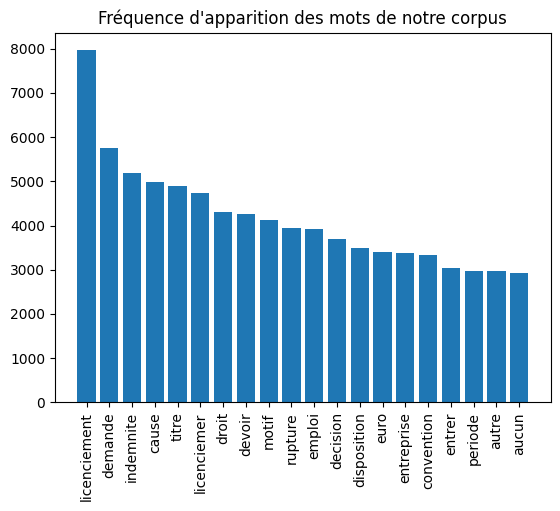

In [12]:
# Visualisation des mots les plus utilisés dans nos documents
freqs = [(word, X_doc_terme.getcol(idx).sum()) for word, idx in vec.vocabulary_.items()]
freqs = sorted(freqs, key=lambda x: -x[1])

plt.bar([x[0] for x in freqs[:20]], [x[1] for x in freqs[:20]])
plt.xticks(rotation=90)
plt.title("Fréquence d'apparition des mots de notre corpus")
plt.show()

Nous visualisons ici les termes les plus utilisés dans les 1000 documents. Les trois termes les plus utilisés sont : "licenciement", "demande", "indemnité".

Création de la matrice TF-IDF, cette mesure permet d'évaluer l'importance d'un terme contenu dans un document. Le poids augmente proportionnellement au nombre d'occurrences du mot dans le document. Il varie également en fonction de la fréquence du mot dans le corpus.

In [13]:
# Création de la matrice tf-idf
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(fin_data['texte_lemma'])

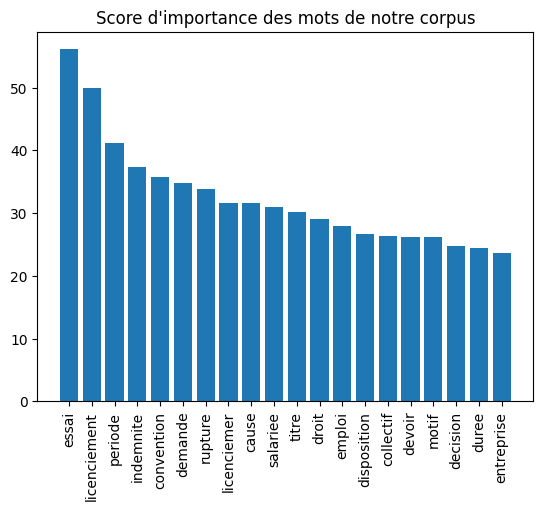

In [14]:
# Visualisation du score d'importance des mots dans nos documents
freqs = [(word, X_tfidf.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]
freqs = sorted(freqs, key=lambda x: -x[1])

plt.bar([x[0] for x in freqs[:20]], [x[1] for x in freqs[:20]])
plt.xticks(rotation=90)
plt.title("Score d'importance des mots de notre corpus")
plt.show()

A l'inverse de la matrice document-terme, nous retrouvons deux mots différents parmi les trois premiers. Le terme "licenciement" est présent dans les deux cas. Mais les mots "essai" et "période" apparaissent dans les premières positions avec le calcul du score d'importance.

#### Classification des documents

Pour la classification de nos documents nous allons supprimer les mots "rupture" et "formation" de nos textes pour éviter que la classification soit faite en fonction de ces mots.

In [15]:
# Suppression des mots concernant la rupture ou la formation
mot_a_enlever = ['rupture', 'ruptur', 'formation']
fin_data['texte_classification'] = fin_data['texte_lemma'].apply(lambda x: supprime_stopwords(x, mot_a_enlever))

In [16]:
# On recalcule la matrice document-terme
vec = CountVectorizer()
X_doc_terme_classif = vec.fit_transform(fin_data['texte_classification'])

Création d'une colonne : le document aura comme valeur "0" s'il correspond au thème de la rupture de contrat de travail et prendra comme valeur "1" sinon. Pour la classification nous utilisons la matrice document-terme.

In [17]:
# Création d'une colonne binaire 
fin_data["theme_bin"] = fin_data["theme"].apply(lambda x: 0 if x == 'contrat de travail, rupture' else 1)

df_X_doc_terme = pd.DataFrame(X_doc_terme_classif.toarray(), columns=vec.get_feature_names_out())
df_X_doc_terme_theme = pd.concat([df_X_doc_terme, fin_data['theme_bin']], axis=1)

Nous séparons le jeu de données en deux groupes : un groupe de "train" pour entraîner l'algorithme et un groupe de "test" pour évaluer les performances de celui-ci. Nous choisissons que 75% des données seront dans le groupe "train" et donc 25% dans le groupe "test".

In [18]:
# Séparation du jeu de données en deux groupes
X = df_X_doc_terme
y = fin_data["theme_bin"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

L'algorithme utilisé sera une forêt aléatoire. Pour optimiser les paramètres de cet algorithme, nous faisons une grille de paramètres à tester puis nous lançons la modélisation. Nous avons en sortie les paramètres qui maximisent le taux de bon classement sur le groupe "test" pour notre forêt aléatoire.

In [19]:
# Random Forest
rf = RandomForestClassifier()

# Réalisation d'une grille de paramètres
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Utilisation de la grille de paramètres
grid_search = GridSearchCV(rf, param_grid=param_grid)
grid_search.fit(X_train, y_train)

print("Meilleurs paramètres : ", grid_search.best_params_)

Meilleurs paramètres :  {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


Nous avons donc récupérés les paramètres optimaux pour notre forêt aléatoire. Nous les utilisons sur notre échantillon de test afin de mesurer la performance du modèle.

In [20]:
forest = RandomForestClassifier(criterion='gini', max_depth=20, min_samples_split=2, n_estimators=200)

# Entrainement du modèle
forest.fit(X_train, y_train)
 
# Mesure de la performance
y_pred = forest.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.940


Nous mesurons la qualité du modèle grâce à l'accuracy, nous avons donc 94% des documents qui sont biens classés.

In [21]:
# Matrice de confusion pour voir quelle est la catégorie la moins bien prédite
pd.crosstab(y_test, y_pred)

col_0,0,1
theme_bin,,
0,124,1
1,14,111


On remarque que les documents sur le thème de la rupture du contrat de travail sont les mieux classés. En effet, parmi les 125 documents de ce thème, un seul a été mal prédit. Tandis que pour les documents avec le thème de la formation de contrat de travail, il y a 14 documents mal prédits.

#### LDA (Latent Dirichlet Allocation)

Pour terminer nous allons appliquer un algorithme de détection de thématique qui nous permettra de différencier nos documents en différents thèmes.
Nous avons choisi de les différencier en 5 thèmes différents, c'est ce qui nous a semblé le plus cohérent lors de nos précédentes analyses. Nous avons testé cet algorithme avec les deux types de matrices créées auparavant (document-terme, tf-idf).

##### LDA avec la matrice document-terme

In [22]:
# Application de la LDA avec la matrice document-terme
lda_doc_terme = LatentDirichletAllocation(n_components=5, random_state=1234)
lda_matrix_doc_terme = lda_doc_terme.fit_transform(X_doc_terme)

terms_doc_terme = vec.get_feature_names_out()

lda_components_doc_terme=lda_doc_terme.components_

# Affichage des cinq thèmes avec les six mots les plus dominants de ces thèmes 
for index, component in enumerate(lda_components_doc_terme):
    zipped = zip(terms_doc_terme, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:6]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Thème "+str(index+1)+": ", top_terms_list)

Thème 1:  ['periodes', 'essai', 'demande', 'fonction', 'disposition', 'droit']
Thème 2:  ['licenciemer', 'cause', 'licencier', 'faute', 'demande', 'fait']
Thème 3:  ['indeniabl', 'titularis', 'euro', 'demande', 'salarial', 'heurer']
Thème 4:  ['licenciemer', 'emploi', 'economiqu', 'motiv', 'plancher', 'cause']
Thème 5:  ['convention', 'rythm', 'indeniabl', 'conventionnel', 'russe', 'disposition']


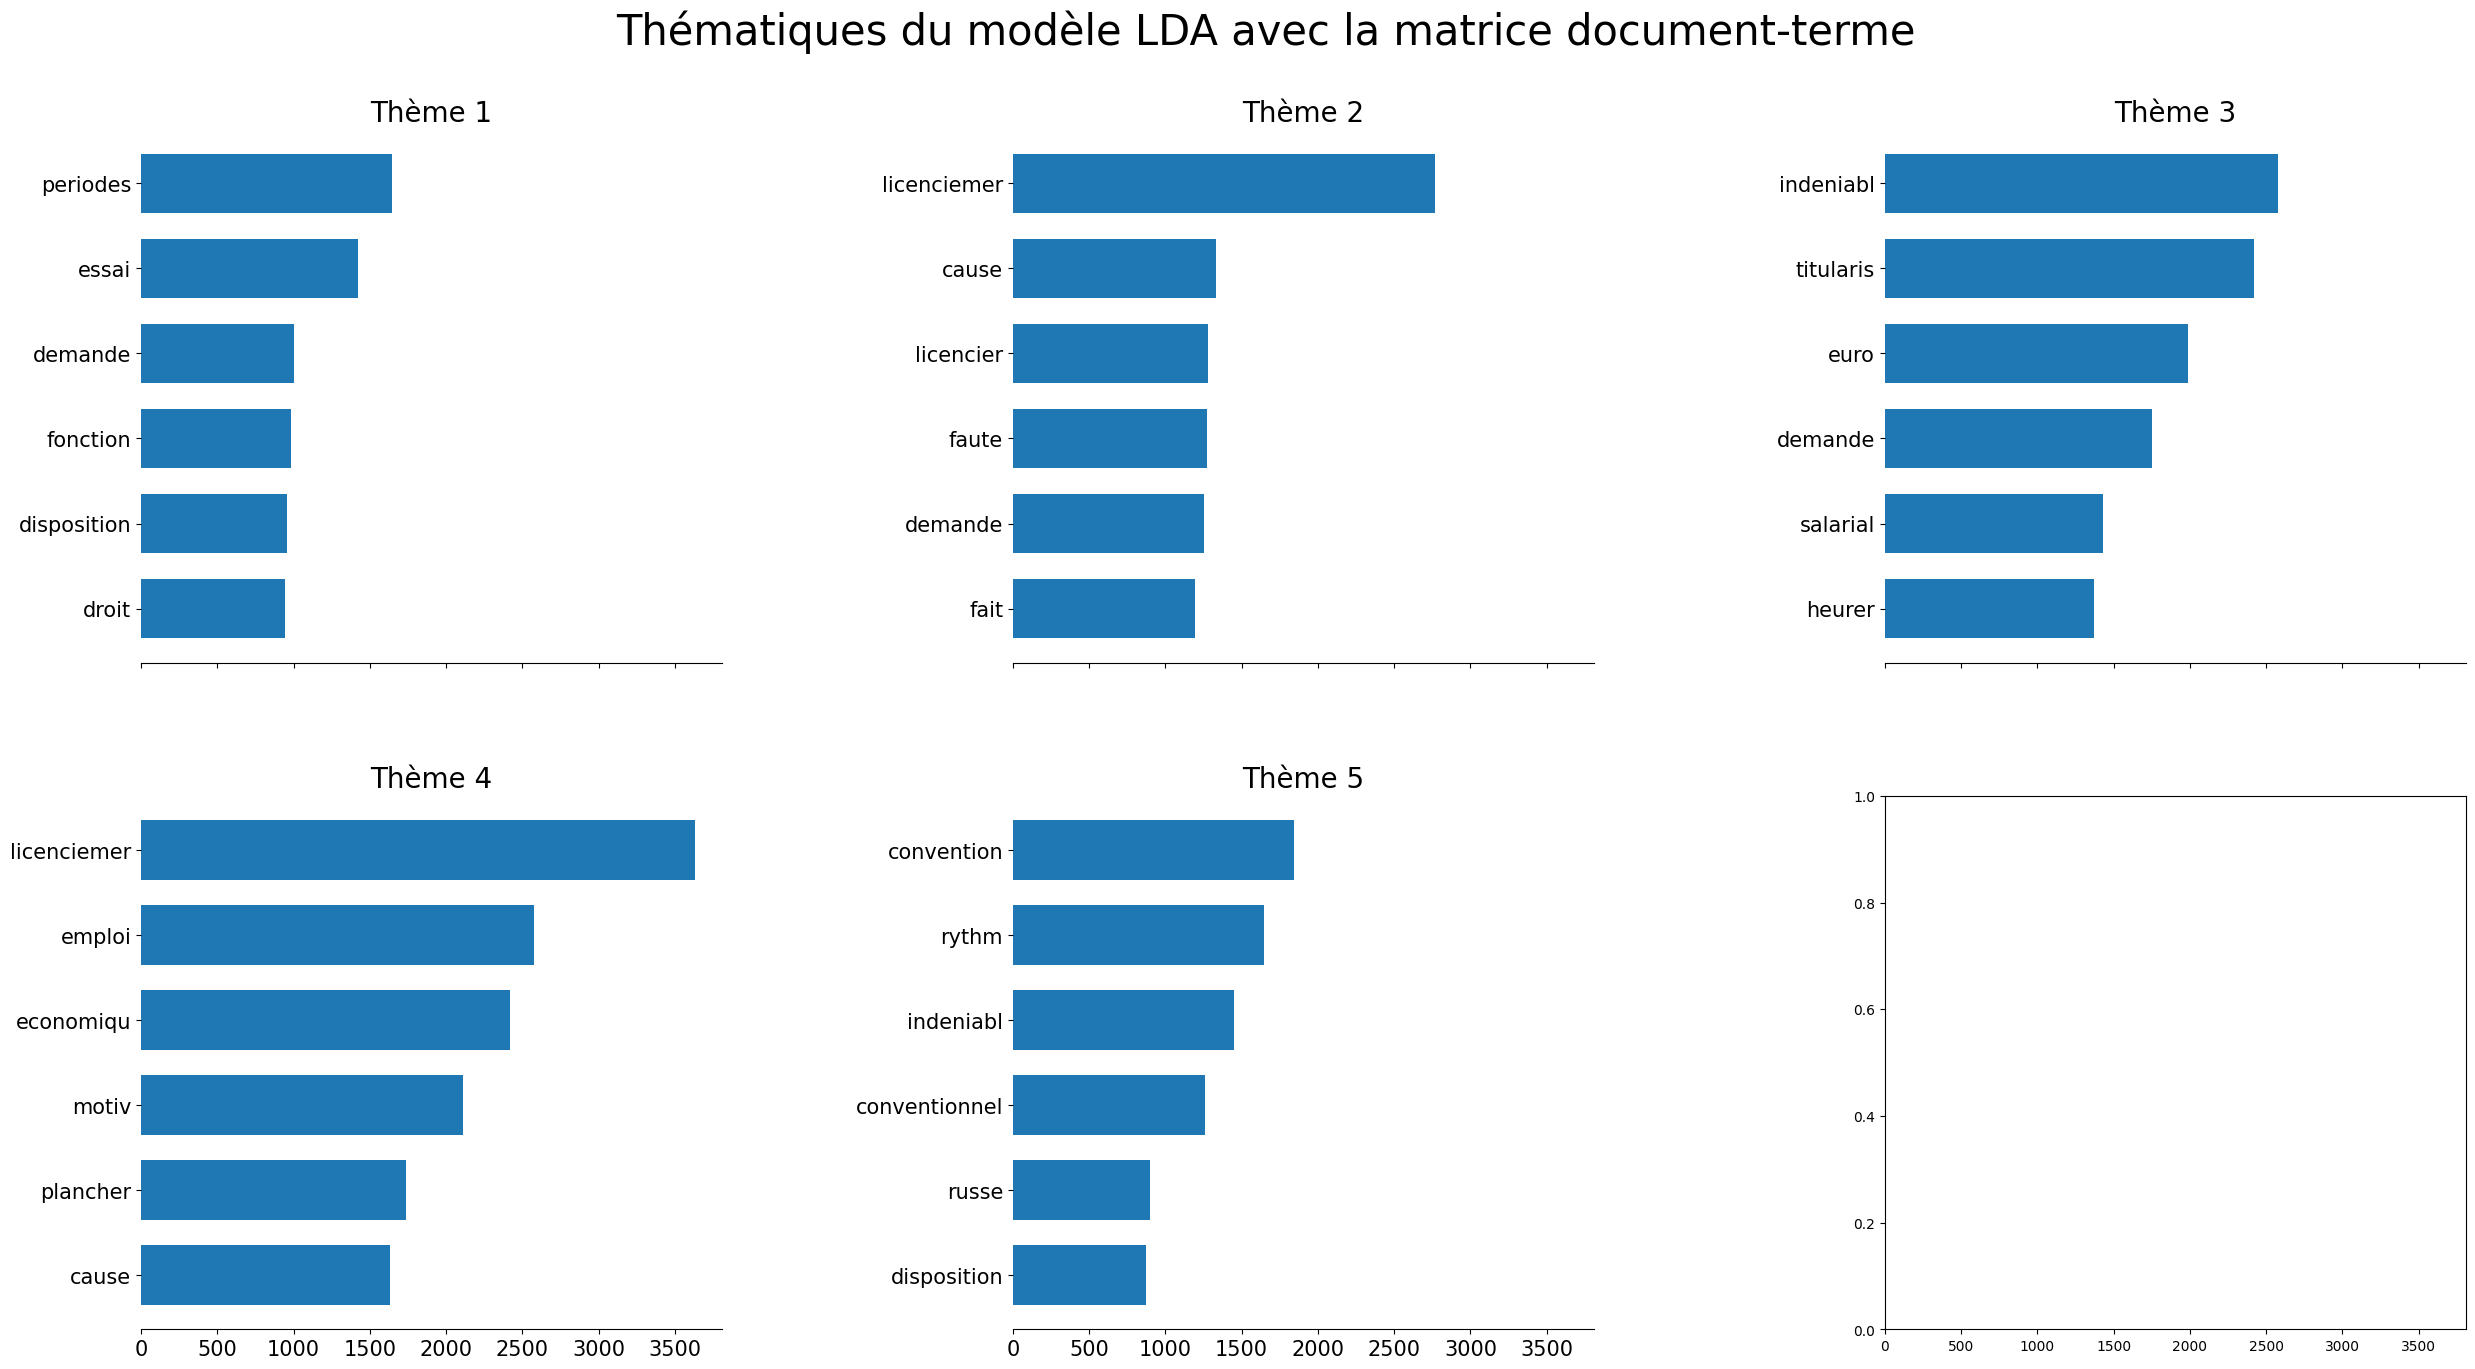

In [23]:
# Fonction qui permet d'afficher les graphiques lors de l'analyse de thématiques
def plot_top_words(model, feature_names, n_top_words, title, lda_components):
    fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for index, topic in enumerate(lda_components):
        top_features_key = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_key]
        weights = topic[top_features_key]
        
        ax = axes[index]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Thème {index +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)

    plt.subplots_adjust(top=0.90, bottom=0.1, wspace=0.50, hspace=0.25)
    plt.show()

n_top_words = 6
plot_top_words(lda_doc_terme, terms_doc_terme, n_top_words, "Thématiques du modèle LDA avec la matrice document-terme", lda_components_doc_terme)

Nous obtenons donc 5 thèmes qui peuvent se résumer ainsi :
1) Les documents qui parlent principalement de période d'essai
2) Les documents résumant le licenciement pour faute du salarié
3) Les documents qui parlent de la thématique de l'argent avec notamment le salaire ou les indemnités
4) Les documents se rapportant principalement au licenciement économique 
5) Les documents traitant du thème de la rupture conventionnelle

A noter que lors de la lemmatisation, le modèle pré-entrainé de nltk transforme les conjugaisons du verbe licencier en verbe licenciemer. On peut le remarquer dans le thème 2.

##### LDA avec la matrice tf-idf

In [24]:
# Application de la LDA avec la matrice tf-idf
lda_tfidf = LatentDirichletAllocation(n_components=5, random_state=1234)
lda_matrix_tfidf = lda_tfidf.fit_transform(X_tfidf)

terms_tfidf = vectorizer.get_feature_names_out()

lda_components_tfidf=lda_tfidf.components_

# Affichage des cinq thèmes avec les six mots les plus dominants de ces thèmes 
for index, component in enumerate(lda_components_tfidf):
    zipped = zip(terms_tfidf, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:6]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Thème "+str(index+1)+": ", top_terms_list)

Thème 1:  ['essai', 'licenciement', 'periode', 'indemnite', 'convention', 'demande']
Thème 2:  ['joueur', 'createur', 'costume', 'rugby', 'decorateur', 'boucle']
Thème 3:  ['houssage', 'inspire', 'dessinee', 'bande', 'paleter', 'colorist']
Thème 4:  ['pasteur', 'erf', 'theologie', 'cultuel', 'ordination', 'populaire']
Thème 5:  ['nicoroi', 'vaccination', 'kali', 'artifice', 'hepatite', 'sage']


On retouve dans le premier thème tous les mots ayant les scores d'importances les plus élevés comme on peut le voir sur le graphique dans la partie d'analyse des documents ci-dessus. Concernant les 4 autres thèmes, nous avons l'impression qu'ils sont très minoritaires et nous avons du mal à dégager une thématique principale. Nous allons visualiser graphiquement ces thématiques par la suite.

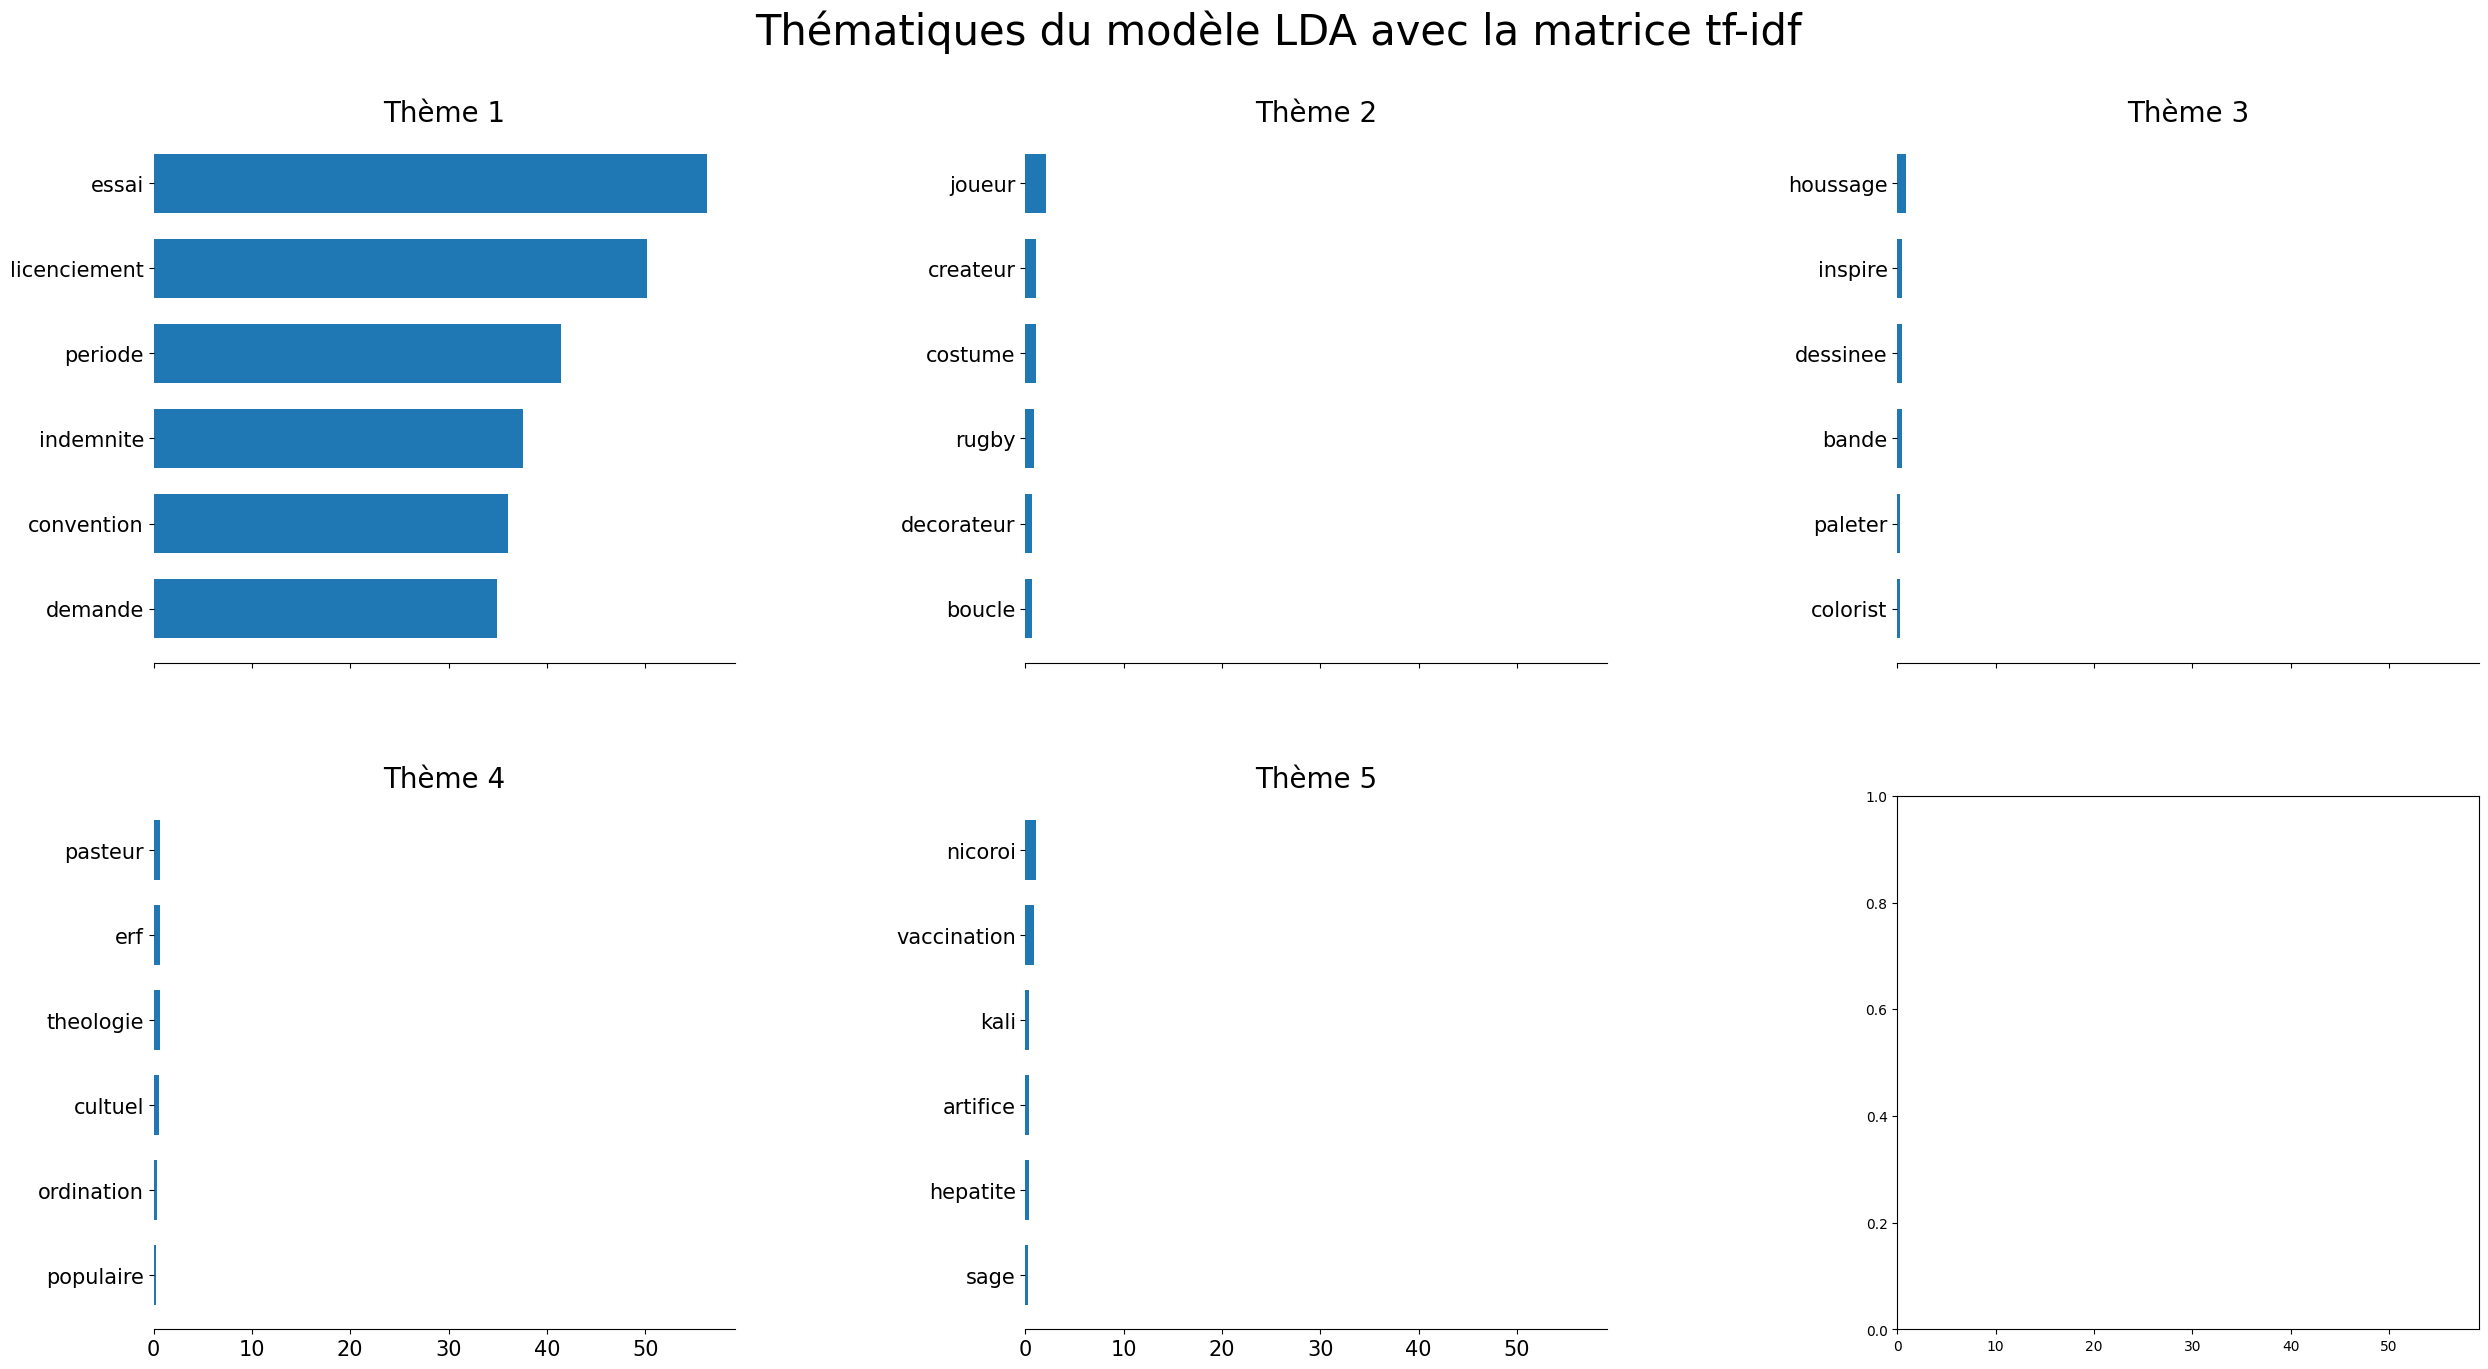

In [25]:
plot_top_words(lda_tfidf, terms_tfidf, n_top_words, "Thématiques du modèle LDA avec la matrice tf-idf", lda_components_tfidf)

Le graphique confirme nos hypothèses, il y a bien un groupe très fourni avec les mots ayant un grand score d'importance. Et quatre autres groupes difficilement identifiables. Nous préférerons nous baser sur la matrice document-terme pour la détection de thématiques qui est beaucoup plus facilement interprétable.

#### LSA (Latent Semantic Analysis)

Nous testons également la LSA qui se concentre sur la signification sémantique des termes. Nous utiliserons simplement la matrice document-terme pour cette analyse.

In [26]:
# Application de la LSA avec la matrice document-terme
lsa_model = TruncatedSVD(n_components=5, random_state=1234)
lsa_topic_matrix = lsa_model.fit_transform(X_doc_terme)

terms_lsa = vectorizer.get_feature_names_out()

lsa_components=lsa_model.components_

# Affichage des cinq thèmes avec les six mots les plus dominants de ces thèmes 
for index, component in enumerate(lsa_components):
    zipped = zip(terms_lsa, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:6]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Thème "+str(index+1)+": ", top_terms_list)

Thème 1:  ['licenciement', 'demande', 'licenciemer', 'cause', 'indemnite', 'titre']
Thème 2:  ['licenciement', 'economiqu', 'emploi', 'plan', 'accord', 'comite']
Thème 3:  ['accord', 'application', 'organisation', 'periode', 'chauffeur', 'salariee']
Thème 4:  ['indemnite', 'accord', 'convention', 'collectif', 'rupture', 'plan']
Thème 5:  ['chauffeur', 'application', 'emploi', 'service', 'plan', 'course']


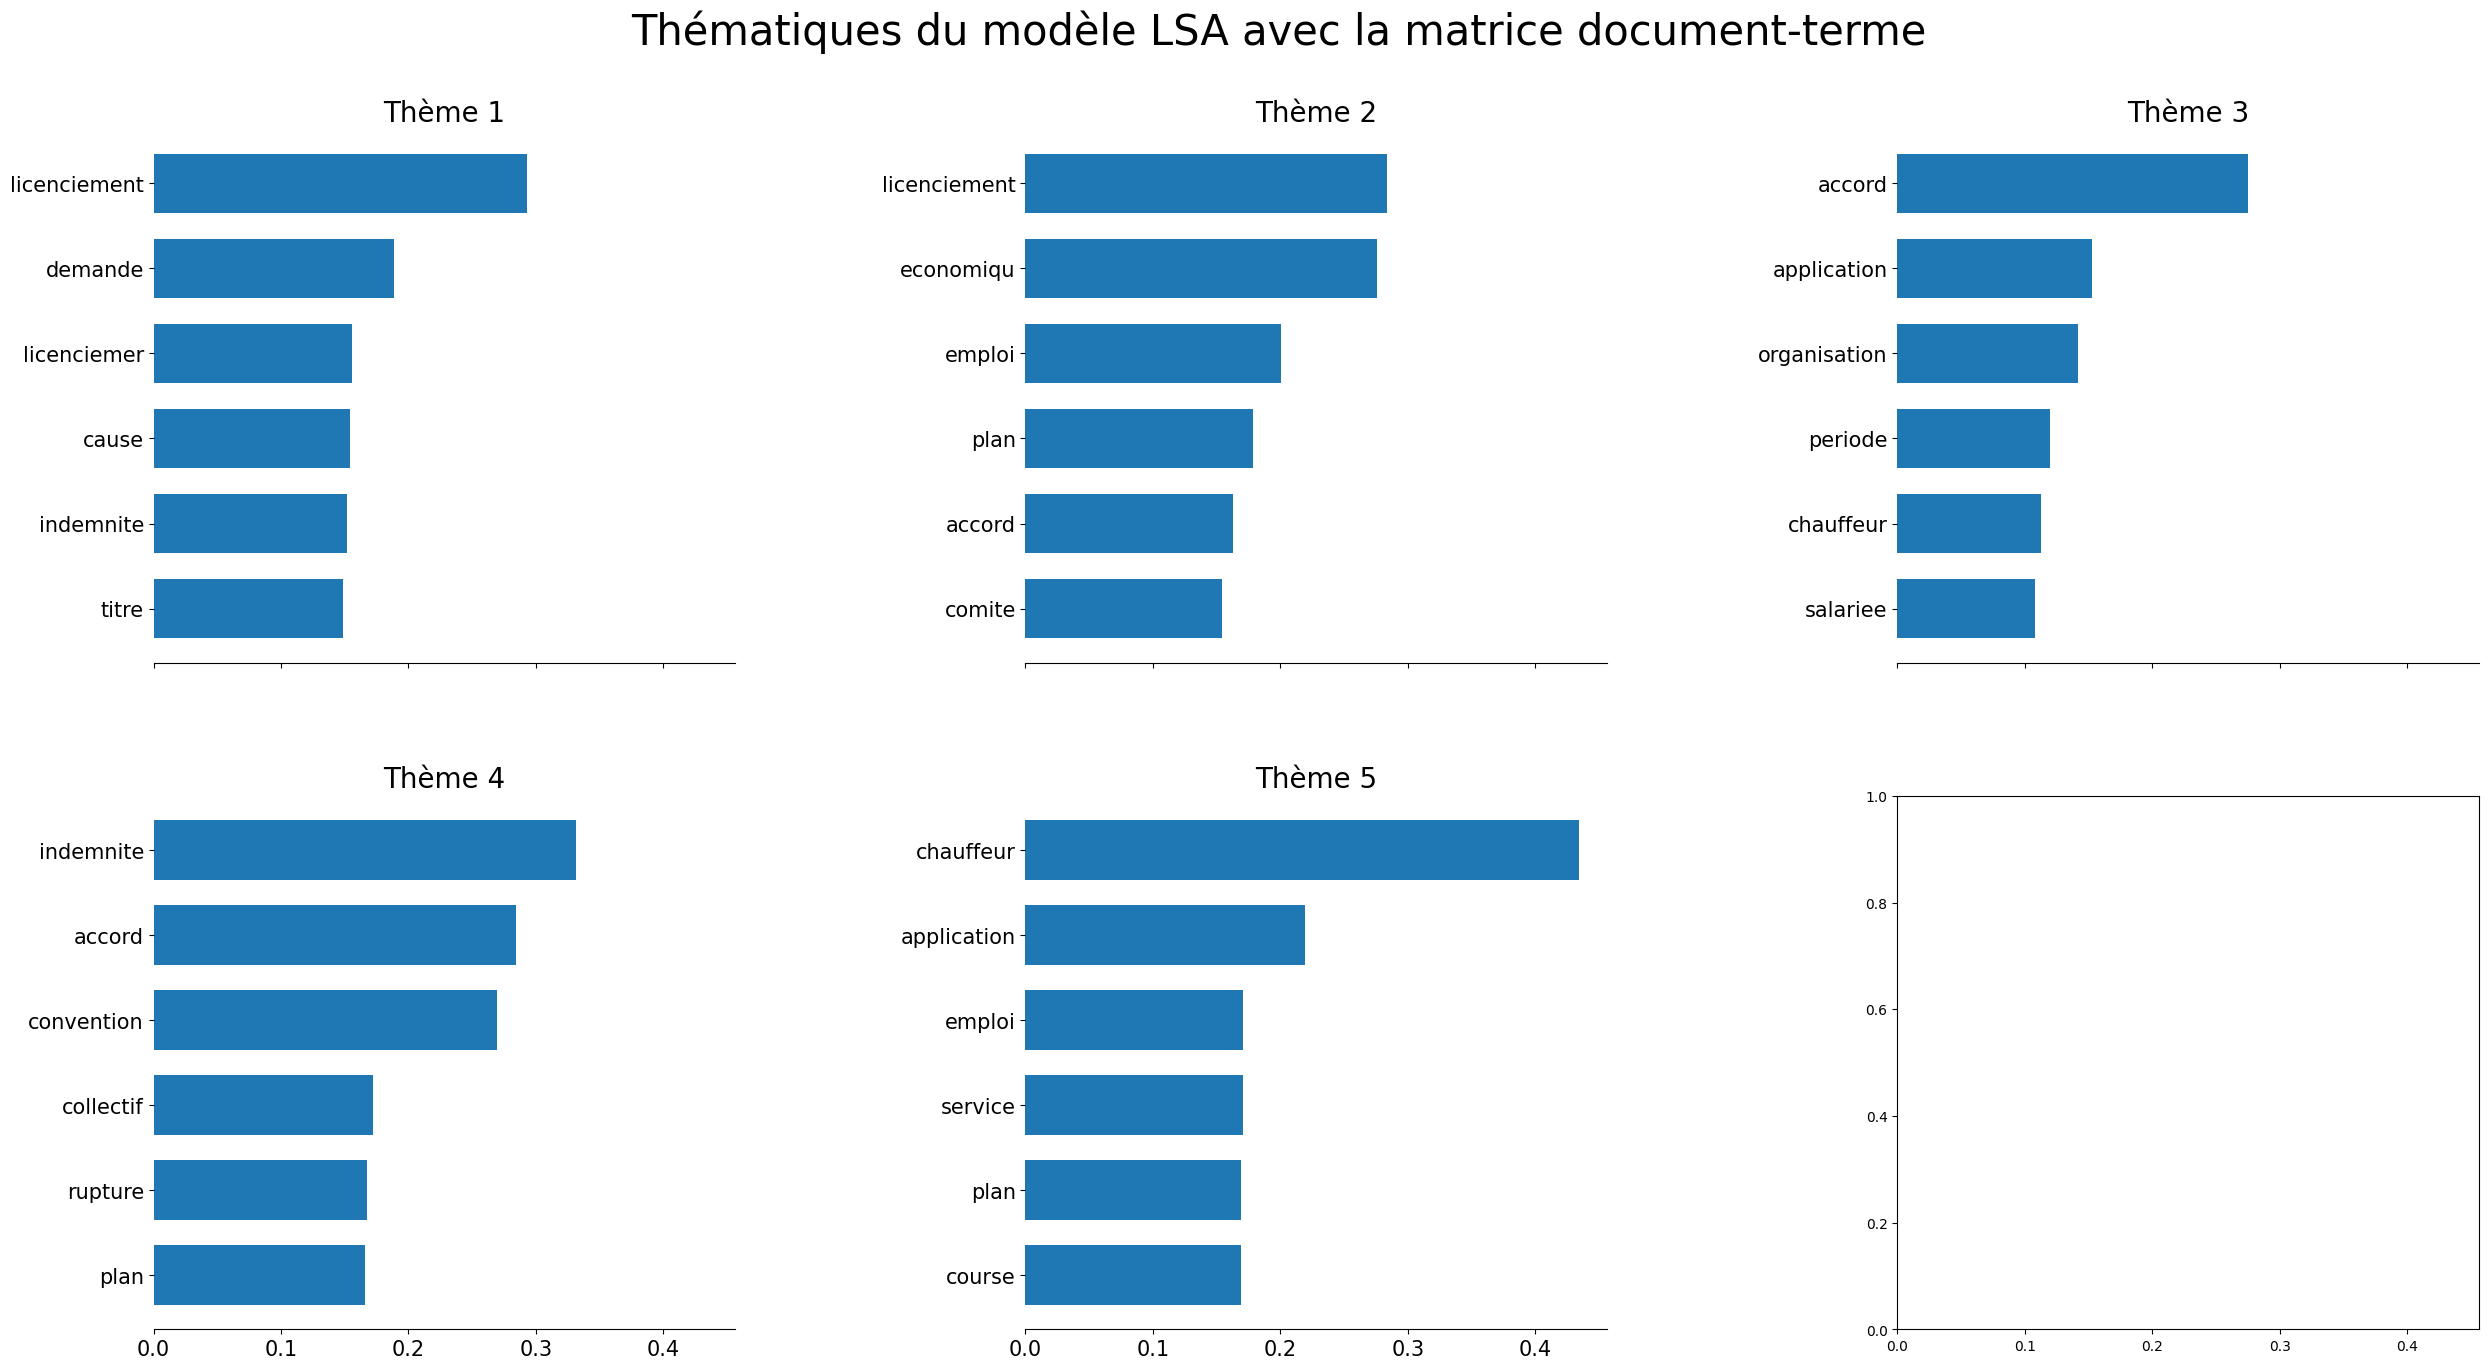

In [27]:
plot_top_words(lsa_model, terms_lsa, n_top_words, "Thématiques du modèle LSA avec la matrice document-terme", lsa_components)

Nous avons choisi cinq thématiques, nous avons testé avec des nombres de groupes différents mais cela n'était pas satisfaisant. Ici nous retrouvons deux groupes sur le licenciement, le premier sur le licenciement en général et le second le licenciement économique. Le groupe trois et cinq parlent tous les deux de chauffeurs, d'application. Cela nous paraît étrange car ces mots ne ressortaient pas lors de notre analyse. Et le groupe quatre semble résumer les documents avec un accord d'indemnité lors d'une rupture.

#### Conclusion

Pour conclure, après avoir nettoyer les données, nous les avons visualisées à travers un nuage de mots permettant de faire ressortir les termes principaux tels que "faire grief", "dommages et interêt" et "salariée". Nous avons ensuite calculé les matrices document-terme et tf-idf pour classifier nos documents et analyser les thématiques. Concernant la classification, nous avons choisi de les classifier suivant les deux thèmes principaux de notre corpus, c'est à dire la formation et la rupture du contrat de travail. Nous obtenons 94% de documents bien classés avec comme algorithme une forêt aléatoire, notre modèle a donc de très bonnes capacités prédictives. Enfin, nous avons testé deux algorithmes de détection de thématiques que sont la LDA et la LSA. Nous avons obtenu de meilleurs résultats avec la LDA en utilisant la matrice document-terme qu'en utilisant la matrice tf-idf. De la même manière les résultats de la LSA nous paraissent moins satisfaisant.

Nous avons choisi 5 thèmes lors de la LDA avec la matrice document-terme, ils sont les suivants :
1) Les documents qui parlent principalement de période d'essai
2) Les documents résumant le licenciement pour faute du salarié
3) Les documents qui parlent de la thématique de l'argent avec notamment le salaire ou les indemnités
4) Les documents se rapportant principalement au licenciement économique 
5) Les documents traitant du thème de la rupture conventionnelle